# Benchmarking Cell Tracking Challenge Data

In [2]:
import logging
import os
from pathlib import Path
import pprint
import urllib.request
import zipfile
import matplotlib.pyplot as plt

from tqdm import tqdm

from traccuracy import run_metrics
from traccuracy.loaders import load_ctc_data
from traccuracy.matchers import CTCMatched, IOUMatched
from traccuracy.metrics import CTCMetrics, DivisionMetrics

pp = pprint.PrettyPrinter(indent=4)
logging.basicConfig(level=logging.INFO)

### Download the GT annotations for a specific example to get started with metrics evaluation:

The following 2 cells automatically download the GT data for the provided dataset. 

_Note:_ In the rare case of getting this error:

```URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:997)>```

...make sure to download the data manually - navigate to the [CTC website](http://celltrackingchallenge.net/2d-datasets/) & download the **training** dataset for [Fluo-N2DL-HeLa](http://data.celltrackingchallenge.net/training-datasets/Fluo-N2DL-HeLa.zip) in the `.zip` format. After unzipping, navigate to the `./Fluo-N2DL-HeLa/01_GT/TRA/` subfolder where 92 manually annotated GT `.tiff` files & a manual tracking `.txt` file should be located. 

And voila, now you're ready to proceed with the rest of the notebook, bypassing the error message!


In [3]:
url = "http://data.celltrackingchallenge.net/training-datasets/Fluo-N2DL-HeLa.zip"
data_dir = 'downloads'

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

filename = url.split('/')[-1]
file_path = os.path.join(data_dir, filename)
ds_name = filename.split('.')[0]

In [ ]:
# Add a utility to make a progress bar when downloading the file
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

if not os.path.exists(file_path):
    print(f"Downloading {ds_name} data from the CTC website")
    # Downloading data
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, file_path, reporthook=t.update_to)
    # Unzip the data
    # TODO add a progress bar to zip as well
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)

### Generate loaders for the `true` and `pred` TrackingGraph objects:

In [5]:
def tracking_graph_data_loader(
    data_dir: str | Path, 
    track_path: str | Path, 
):
    return load_ctc_data(
        data_dir=data_dir, 
        track_path=track_path
    )

In [6]:
true_data, true_track = 'downloads/Fluo-N2DL-HeLa/01_GT/TRA', 'downloads/Fluo-N2DL-HeLa/01_GT/TRA/man_track.txt'
pred_data, pred_track = 'sample-data/Fluo-N2DL-HeLa/01_RES', 'sample-data/Fluo-N2DL-HeLa/01_RES/res_track.txt'


### Run CTC metrics with additional evaluation of division events:

This function is implemented over multiple frame buffers to add less constraints on division detection. 

In [7]:
ctc_results = run_metrics(
    gt_data=tracking_graph_data_loader(true_data, true_track), 
    pred_data=tracking_graph_data_loader(pred_data, pred_track), 
    matcher=CTCMatched, 
    metrics=[CTCMetrics, DivisionMetrics],
    metrics_kwargs=dict(
        frame_buffer=(0,1,2)
    )
)
pp.pprint(ctc_results)

Matching frames: 100%|██████████| 92/92 [00:00<00:00, 104.49it/s]
INFO:traccuracy.matchers._matched:Matched 8600 out of 8639 ground truth nodes.
INFO:traccuracy.matchers._matched:Matched 8600 out of 8600 predicted nodes.
Evaluating FN edges: 100%|██████████| 8562/8562 [00:00<00:00, 1147886.55it/s]


{   'CTCMetrics': {   'AOGM': 627.5,
                      'DET': 0.9954855886097927,
                      'TRA': 0.993676498745377,
                      'fn_edges': 87,
                      'fn_nodes': 39,
                      'fp_edges': 60,
                      'fp_nodes': 0,
                      'ns_nodes': 0,
                      'ws_edges': 47},
    'DivisionMetrics': {   'Frame Buffer 0': {   'Division F1': 0.76,
                                                 'Division Precision': 0.7169811320754716,
                                                 'Division Recall': 0.8085106382978723,
                                                 'False Negative Divisions': 18,
                                                 'False Positive Divisions': 30,
                                                 'Mitotic Branching Correctness': 0.6129032258064516,
                                                 'True Positive Divisions': 76},
                           'Frame Buffer 1': 

### Use an IOU matcher which supports a minimum threshold for overlap and run division metrics:

In [ ]:
iou_results = run_metrics(
    gt_data=tracking_graph_data_loader(true_data, true_track), 
    pred_data=tracking_graph_data_loader(pred_data, pred_track), 
    matcher=IOUMatched, 
    matcher_kwargs=dict(
        iou_threshold=0.5
    ),
    metrics=[DivisionMetrics], 
    metrics_kwargs=dict(
        frame_buffer=(0, )
    )
)
pp.pprint(iou_results)

Matching frames: 100%|██████████| 92/92 [00:05<00:00, 15.41it/s]
INFO:traccuracy.matchers._matched:Matched 1617 out of 8639 ground truth nodes.
INFO:traccuracy.matchers._matched:Matched 1617 out of 8600 predicted nodes.


{   'DivisionMetrics': {   'Frame Buffer 0': {   'Division F1': 0,
                                                 'Division Precision': 0.0,
                                                 'Division Recall': 0.0,
                                                 'False Negative Divisions': 94,
                                                 'False Positive Divisions': 93,
                                                 'Mitotic Branching Correctness': 0.0,
                                                 'True Positive Divisions': 0}}}


### Use a range of IoU thresholds to monitor how the IoU influences the scoring of divisions:

These 19 iterations should take around ~2.5 minutes to compute in total. 

In [ ]:
iou_range = [i / 100 for i in range(10, 105, 5)]
frm = 0
    
metrics_by_iou = {}
for iou in iou_range:
    print (f"IoU = {iou} for frame buffer {frm}")

    iou_results = run_metrics(
        gt_data=tracking_graph_data_loader(true_data, true_track), 
        pred_data=tracking_graph_data_loader(pred_data, pred_track), 
        matcher=IOUMatched, 
        matcher_kwargs=dict(iou_threshold=iou),
        metrics=[DivisionMetrics], 
        metrics_kwargs=dict(frame_buffer=(frm, ))
    )

    # Append the metric by IoU
    metrics_by_iou[iou] = iou_results['DivisionMetrics'][f'Frame Buffer {frm}']
    

### Plot the results on a figure:

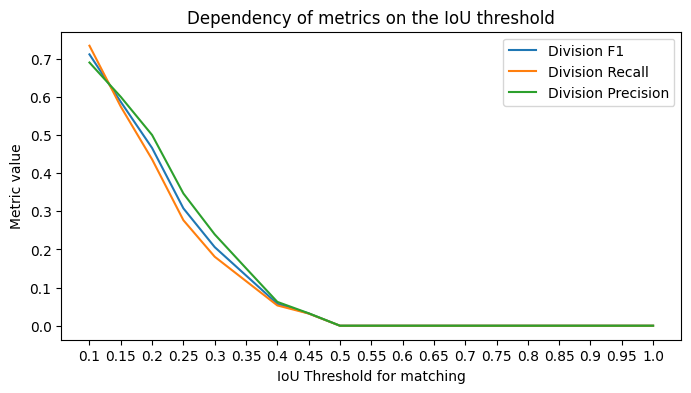

In [53]:
plt.figure(figsize=(8, 4))

for key in ("Division F1", "Division Recall", "Division Precision"):
    plt.plot([metrics_by_iou[iou][key] for iou in iou_range], label=key)

plt.xticks(ticks=range(len(iou_range)), labels=iou_range)
plt.title("Dependency of metrics on the IoU threshold")
plt.xlabel("IoU Threshold for matching")
plt.ylabel("Metric value")
plt.legend()
plt.show()


##### Done!